## Listings Analysis

In this section we take a look at the `listings.csv` files per city. Our main goal is to provide insights into the relation between amenities offered and bookings and whether this relation varies depending on the city.

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from pathlib import Path
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Import internal modules
sys.path.append('..')
from src.config import config as cf
from src import data as dt

## matplotlib configurations
%matplotlib inline
plt.style.use('fivethirtyeight')



In [2]:
## Read .csv data
b_listings = pd.read_csv(cf.data_dir.joinpath('raw').joinpath('boston_listings.csv'))
s_listings = pd.read_csv(cf.data_dir.joinpath('raw').joinpath('seattle_listings.csv'))

b_listings['city'] = 'Boston'
s_listings['city'] = 'Seattle'

listings = b_listings.append(s_listings, sort = False)

The dataframe has in total 7403 rows and 95 features.

There are the following number of features per type:

object     65
float64    17
int64      13
dtype: int64

54.74% of the features have missing values


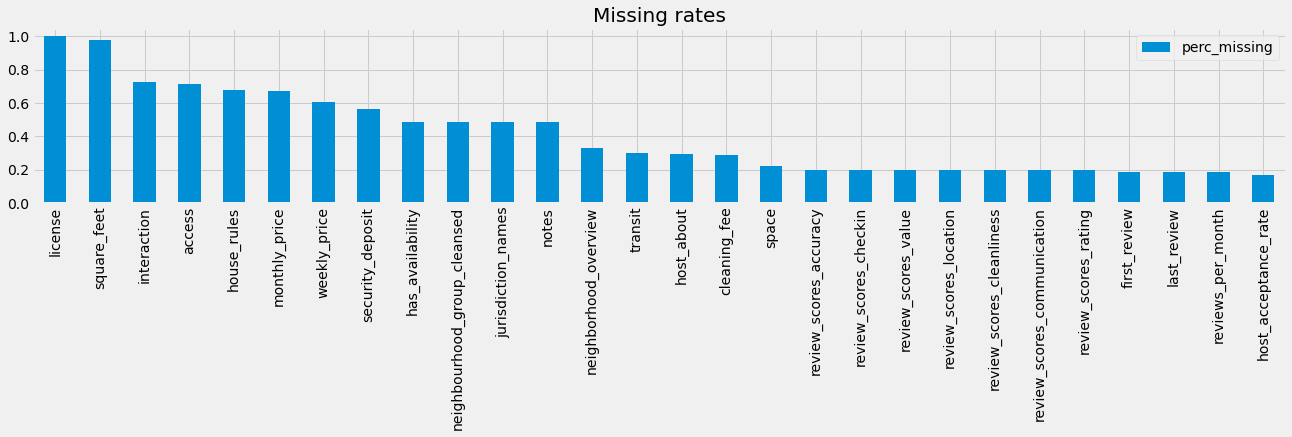

In [3]:
# listings.columns.sort_values ()
# listings.dtypes
plt.rcParams['figure.figsize'] = (20,3)

dt.data_first_look(listings, perc_missing = 0.15)


### Data cleaning

For our research question we focus on amenities, availability, and city.

In [4]:
df = listings[["amenities", 'availability_30', "city"]].reset_index(drop = True)
df.isnull().sum()


amenities          0
availability_30    0
city               0
dtype: int64

At first glance, the selected columns don't have missing values. There is, however, a formatting issue regarding the amenities column: a single column can contain multiple amenities, as the values are in a string separated by commas. Therefore additional operations are needed.

We first drop entries with '{}' which means the amenities are empty

In [5]:
## No. of empty amenities
print('There are {} entries with empty amenities'.format(np.sum(df['amenities'] == '{}')))

df = df[df['amenities'] != '{}']

There are 77 entries with empty amenities


Second, we split the comma-separated-amenities using dummy variables

In [7]:
dummies_amenities = pd.get_dummies(
    df['amenities'].str.replace('}','').str.replace('{','').str.split(',').apply(pd.Series).stack()
).sum(level = 0).reset_index(drop = True)
dummies_amenities.head()

C:\Users\zamorem\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,1,1,0,0,...,0,1,1,1,1,1,0,1,1,1
2,0,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,1,1,1
3,0,1,0,0,1,0,0,1,1,1,...,1,1,1,1,1,1,0,1,1,1
4,0,1,0,0,1,0,0,0,1,0,...,0,1,1,1,1,1,0,1,0,0


The resulting encoded dataframe of amenities can be then joined to the original dataframe. At the same time, we drop the original amenities columns, since it is no longer needed.

In [8]:
# df_dummies = df.join(dummies_amenities)#.drop(['amenities'], axis = 1)
df_dummies = pd.concat([df, dummies_amenities], axis = 1).drop(['amenities'], axis = 1)
df_dummies.head()

,availability_30,city,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0.0,Boston,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1,26.0,Boston,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,19.0,Boston,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3,6.0,Boston,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,13.0,Boston,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


Lastly, the availability column could be interpreted as the reverse measure of bookability: the least avaiable a listing is, the more often is booked. Thus we can transform the average availability per day into a booking ration as follows:

In [25]:
df_dummies['booking_ratio'] =  1 - df_dummies['availability_30']/30
df_dummies.drop(['availability_30'], axis = 1, inplace = True)

KeyError: 'availability_30'

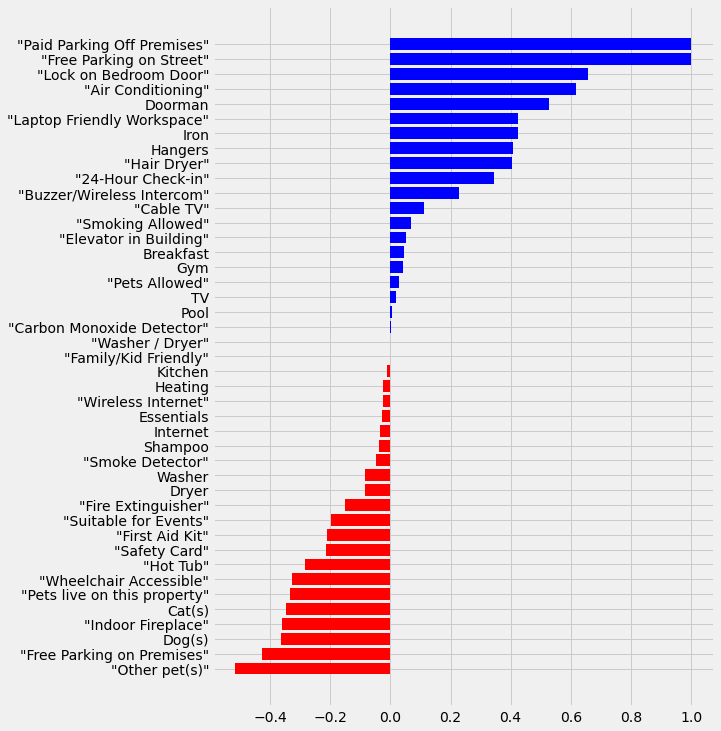

In [144]:
agg_amenities = df_dummies.drop('booking_ratio', axis = 1).groupby('city').sum().reset_index(level = 0).melt(id_vars = 'city', var_name = 'amenity', value_name = 'count')
agg_amenities = agg_amenities.pivot(index = 'amenity', columns = 'city', values = 'count').reset_index()
agg_amenities = agg_amenities[~agg_amenities.amenity.str.contains("translation")]
agg_amenities['Delta'] = (agg_amenities.Boston - agg_amenities.Seattle) / (agg_amenities.Boston + agg_amenities.Seattle)
agg_amenities = agg_amenities.sort_values(by = 'Delta')

my_color = np.where(agg_amenities['Delta'] >=0, 'blue', 'red')
legend_elm = [Patch(facecolor='blue', label='Boston'), Patch(facecolor='red', label='Seattle')]

plt.rcParams['figure.figsize'] = (8,12)
plt.barh(agg_amenities['amenity'], agg_amenities['Delta'], color=my_color);
# plt.legend(handles=legend_elm, loc='center');

# plt.rcParams['figure.figsize'] = (10,10)
# plt.subplot(1,2,1)
# plt.barh(agg_amenities['amenity'], agg_amenities['Boston'], align = 'center')
# plt.subplot(1,2,2)
# plt.barh(agg_amenities['amenity'], agg_amenities['Seattle'], align = 'center')
# plt.rcParams['figure.figsize'] = (20,30)
# plt.subplot(1,2,1)
# sns.catplot(data = agg_amenities, y  = 'amenity', x = 'Boston');
# plt.subplot(1,2,2)
# sns.catplot(data = agg_amenities, y  = 'amenity', x = 'Seattle');

# df['amenities'].str.replace('}','', regex = False).str.replace('{','', regex = False).str.split(',')#.apply(pd.Series)#.stack()

### Modelling 

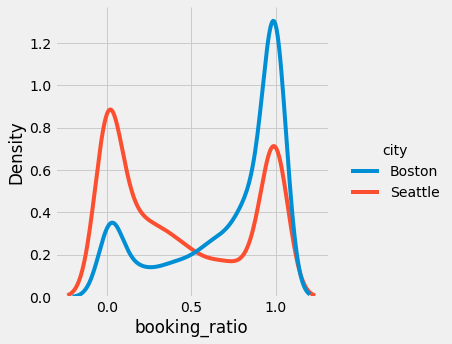

In [24]:
sns.displot(data = df_dummies, x = 'booking_ratio', hue = 'city', kind = 'kde');

For this section wer aim to model the relation between amenities and the booking ratio for each city separatelly. Then we can compare the coefficients (*i.e.*, impact) on each citie's resulting model. By directly inspecting the histogram of the 

In [22]:
## Model for Boston
X = df_dummies.loc[df_dummies['city'] == 'Boston'].drop('booking_ratio', axis = 1)
y = df_dummies.loc[df_dummies['city'] == 'Boston']['booking_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)